# Regularization and Dropout

In this notebook, we will analyze the regularization and dropout effect in the results of a neural network. For the exercise we will use a FFN to classify pieces of clothing in the well-known Fashion-MNIST dataset (https://github.com/zalandoresearch/fashion-mnist). 

Let's start loading the neecssary libraries:
* Pytorch
* Numpy
* Torchvision to load the data
* Matplotlib to plot results and images
* ...

In [1]:
import torch
import numpy as np
import torchvision
import torchvision.transforms as tr
import matplotlib.pyplot as plt
import torch.nn as nn
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sn

## Load the data

The library torchvision is used to load the Fashion-MNIST dataset and then is transformed into tensors that can be used by the torch library. The tensors with the data will be fetched using a dataloader.



In [2]:
all_tr = tr.Compose([tr.ToTensor()])

train_set = torchvision.datasets.FashionMNIST(root="./", download=True, 
                                              train=True,
                                              transform=all_tr)

test_set = torchvision.datasets.FashionMNIST(root="./", download=True, 
                                              train=False,
                                              transform=all_tr)

train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=50, shuffle=True) # The batch size is 5 but can be increase to better performance.
test_dataloader = torch.utils.data.DataLoader(test_set, batch_size=50, shuffle=True) 

Images in the dataset and its labels:

Label: 0
Label: T-shirt/top


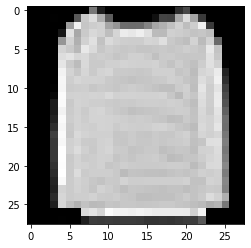

In [3]:
# The dataloader will return a iterable over the Fashion-MNIST dataset. Each batch have a set of images (28x28) and its label 
images, labels = next(iter(train_dataloader))

image = images[0]
label = labels[0]

plt.imshow(image.squeeze(), cmap="gray")
print(f'Label: {label.item()}')

# The labels need to be transformed to teh correct description:
lbl_mapping = {0: 'T-shirt/top', 1:	'Trouser', 2: 'Pullover', 3: 'Dress', 4: 'Coat', 5: 'Sandal', 6: 'Shirt', 7: 'Sneaker', 8: 'Bag', 9: 'Ankle boot'}
print(f'Label: {lbl_mapping[label.item()]}')

## The Neural Network

In [4]:
# We create a new class "FFNetwork" from nn.Module that implement a simple Feed Forward Network
class FFNetwork(nn.Module):
    # Constructor
    def __init__(self):
        super().__init__()

        # A single hidden layer with 100 units
        self.layers = nn.Sequential(
            nn.Flatten(),        # Convert 28 x 28 images into a flat tensor
            nn.Linear(784, 100), # 28 x 28 = 784 inputs; 100 outputs
            nn.ReLU(),           # Add ReLU activation
            nn.Linear(100, 10)   # 100 inputs; 10 outputs (10 classes: 'T-shirt/top', 'Trouser', 'Pullover', ..., 'Ankle boot')
        )

    # Forward method  
    def forward(self, x): 
        # with the input "x" evaluet it in the layers of teh network
        out = self.layers(x)
        return out

Without training, what is the prediction of the network?

In [5]:
# Create an instance of the network
ffnet = FFNetwork()

# Run the sample through the network
output = ffnet(images)

# Let's check the first 10 classification
for i in range(10): #output.shape[0]
    y_hat = torch.argmax(output[i, :]).item()
    y = labels[i].item()
    print(f'Image {i}')
    print(f'Predited label: {lbl_mapping[y_hat]}')
    print(f'Actual label: {lbl_mapping[y]}')

Image 0
Predited label: Dress
Actual label: T-shirt/top
Image 1
Predited label: Dress
Actual label: Sneaker
Image 2
Predited label: Dress
Actual label: Sandal
Image 3
Predited label: Dress
Actual label: Ankle boot
Image 4
Predited label: Dress
Actual label: Sneaker
Image 5
Predited label: Dress
Actual label: Sneaker
Image 6
Predited label: Pullover
Actual label: Dress
Image 7
Predited label: Dress
Actual label: T-shirt/top
Image 8
Predited label: Pullover
Actual label: Sandal
Image 9
Predited label: Dress
Actual label: T-shirt/top


## Prepare the Training
Let's create two methods that will be useful for the next steps. The first makes predictions on a network and the second trains the network.

In [6]:
def get_predictions(model, dataloader, loss_function=nn.CrossEntropyLoss()):
    """
       Receive a model, a dataloader and a lost function, perform the predictions and 
       return the predited value, the actual value and the lost.
    """
    with torch.no_grad():
        y_hat = torch.tensor([])
        y = torch.tensor([])

        loss = []

        for image, label in dataloader:
            output = model(image)
            l = loss_function(output, label)
            loss.append(l)

  
            # Add them to the tensor
            y_hat = torch.cat((y_hat, output.argmax(1)), dim=0)
            y = torch.cat((y, label), dim=0)

    return y_hat, y, torch.tensor(loss).mean().item()



def train(model, train_dl, test_dl, epochs, loss_function, optimizer):
    """
       Receive a model, a dataloader to train, a dataloader to test, number of epoch 
       to train, a lost function, and an optimazer perform the treining and 
       return vetors with the loss and accuracy.
    """
    # Reset data loader
    iter(train_dataloader)
    iterations = []
    train_loss = []
    train_accuracy = []
    test_accurancy = []
    test_loss = []
    for ep in range(epochs):
        print(f'   Training epoch: {ep}')
        
        # Keep track of the loss during training
        batch_loss = []
        batch_accuracy = []
        
        # We use our data loader to fetch batches from our dataset
        for Xbatch, ybatch in train_dl:

            # We first zero-out the gradients
            optimizer.zero_grad()
            
            # Compute output
            output = model(Xbatch)

            # Get loss
            l = loss_function(output, ybatch)

            # # Get Accuracy
            a = (output.argmax(1) == ybatch).sum() / len(ybatch) #* 100 


            # Compute gradients
            l.backward()

            # Perform optimization step
            optimizer.step()

            batch_loss.append(l)
            batch_accuracy.append(a)

        iterations.append(ep)
        train_loss.append(torch.tensor(batch_loss).mean().item())
        train_accuracy.append(torch.tensor(batch_accuracy).mean().item())

        test_y_hat, test_y, t_lost = get_predictions(model, test_dl, loss_function)
        test_loss.append(t_lost)
        t_accurancy = (test_y_hat == test_y).sum() / len(test_y)
        test_accurancy.append(t_accurancy)
        
        # print(f'    Training loss: %.4f' % torch.tensor(batch_loss).mean().item())
        # print(f'Training accuracy: %.4f' % torch.tensor(batch_accuracy).mean().item())
        # print(f'        Test loss: %.4f' % t_lost)
        # print(f'    Test accuracy: %.4f' % t_accurancy)

    return iterations, train_loss, train_accuracy, test_loss, test_accurancy



## Train the Network without regularization

And finally we are ready to train the network. First we will train the network without any regularization. The regularization is defined in the optimization algorithm. We will select the optimization algorithm "SGD" (stochastic gradient descent https://pytorch.org/docs/stable/generated/torch.optim.SGD.html#torch.optim.SGD). The L2 penalty regularization is implemented using the parameter "weight_decay" that in this first training will be equal to "0".

1. Without regularization

   Training epoch: 0
   Training epoch: 1
   Training epoch: 2
   Training epoch: 3
   Training epoch: 4
   Training epoch: 5
   Training epoch: 6
   Training epoch: 7
   Training epoch: 8
   Training epoch: 9
   Training epoch: 10
   Training epoch: 11
   Training epoch: 12
   Training epoch: 13
   Training epoch: 14
   Training epoch: 15
   Training epoch: 16
   Training epoch: 17
   Training epoch: 18
   Training epoch: 19


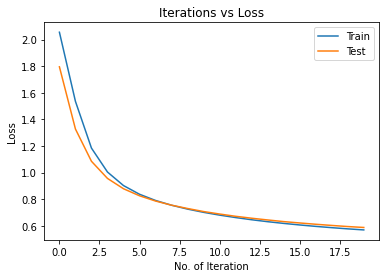

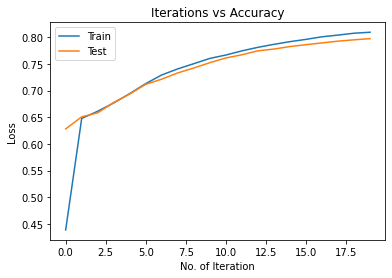

In [7]:
EPOCHS = 20
loss = nn.CrossEntropyLoss()

# In the definition of the optimizer is set:
#   - The parameters of the network to optimaze
#   - The learning rate 
#   - The weight_decay (L2 regularization) has the default value = 0
optimizer = torch.optim.SGD(ffnet.parameters(), lr=0.001)

iterations, train_loss, train_accuracy, test_loss, test_accurancy = train(ffnet, train_dataloader, test_dataloader, EPOCHS, loss, optimizer)

plt.plot(iterations, train_loss, label="Train")
plt.plot(iterations, test_loss, label="Test" )
plt.xlabel("No. of Iteration")
plt.ylabel("Loss")
plt.title("Iterations vs Loss")
plt.legend()
plt.show()

plt.plot(iterations, train_accuracy, label="Train")
plt.plot(iterations, test_accurancy, label="Test" )
plt.xlabel("No. of Iteration")
plt.ylabel("Loss")
plt.title("Iterations vs Accuracy")
plt.legend()
plt.show()

With The trained network check the loss, accuracy and the confusion_matrix on the train and test dataset 

Train Accuracy: 0.8118166923522949
Train lost: 0.5646820664405823
Test Accuracy: 0.7972999811172485
Test lost: 0.5873246192932129


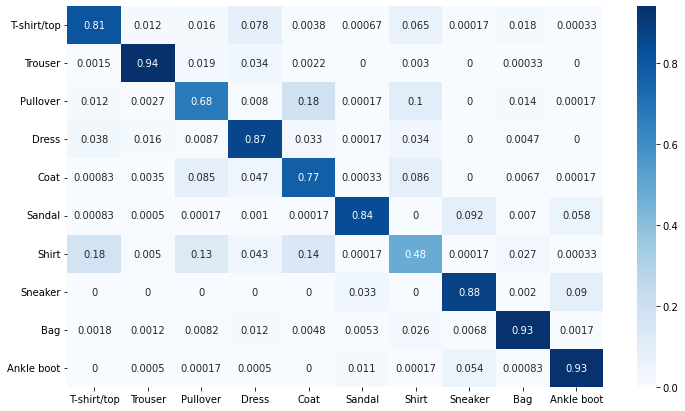

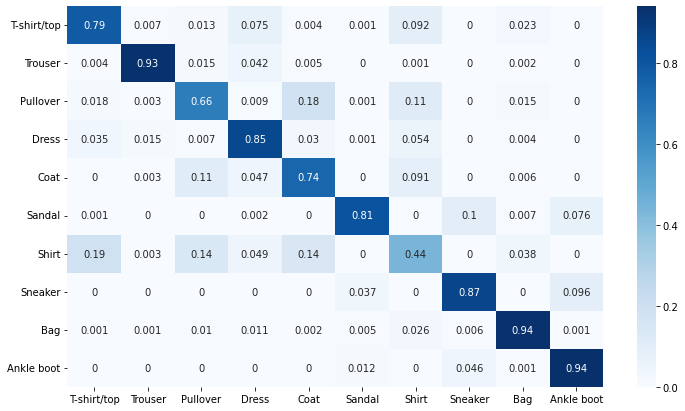

In [8]:
def model_performace(model, train_dl, test_dl):
    """
    This method print the performence of the model and confusion matrix in the test and train datasets.
    """
    # Reset data loaders
    iter(train_dataloader)
    iter(test_dataloader)

    # Train 
    y_hat, y, train_lost = get_predictions(model, train_dl)
    cm_train = confusion_matrix(y_true=y, y_pred=y_hat)

    cm_train = cm_train/np.sum(cm_train) * 10
    
    plt.figure(figsize = (12,7))
    cm_train_df = pd.DataFrame(cm_train, index = [lbl_mapping[x] for x in lbl_mapping] , columns = [lbl_mapping[x] for x in lbl_mapping])
    sn.heatmap(cm_train_df, annot=True, cmap='Blues')

    accuracy = (y_hat == y).sum() / len(y)
    print('Train Accuracy:', accuracy.item())
    print('Train lost:', torch.tensor(train_lost).mean().item())

    # Test 
    y_hat, y, test_lost = get_predictions(model, test_dl)
    cm_test = confusion_matrix(y_true=y, y_pred=y_hat)

    cm_test = cm_test/np.sum(cm_test) * 10

    plt.figure(figsize = (12,7))
    cm_test_df = pd.DataFrame(cm_test, index = [lbl_mapping[x] for x in lbl_mapping] , columns = [lbl_mapping[x] for x in lbl_mapping])
    sn.heatmap(cm_test_df, annot=True, cmap='Blues')

    accuracy = (y_hat == y).sum() / len(y)
    print('Test Accuracy:', accuracy.item())
    print('Test lost:', torch.tensor(test_lost).mean().item())

model_performace(ffnet, train_dataloader, test_dataloader)

Let's to see some preditions with this trained model

In [9]:
# Use the test dataset
images, labels = next(iter(test_dataloader))

# Run the sample through the network
output = ffnet(images)

# Let's check the first 10 classification
for i in range(10): #output.shape[0]
    y_hat = torch.argmax(output[i, :]).item()
    y = labels[i].item()
    print(f'         Image: {i}')
    print(f'Predited label: {lbl_mapping[y_hat]}')
    print(f'  Actual label: {lbl_mapping[y]}')


         Image: 0
Predited label: Sandal
  Actual label: Sandal
         Image: 1
Predited label: Sneaker
  Actual label: Sneaker
         Image: 2
Predited label: Coat
  Actual label: Coat
         Image: 3
Predited label: Shirt
  Actual label: Shirt
         Image: 4
Predited label: Bag
  Actual label: Pullover
         Image: 5
Predited label: T-shirt/top
  Actual label: T-shirt/top
         Image: 6
Predited label: Dress
  Actual label: Shirt
         Image: 7
Predited label: Sneaker
  Actual label: Sneaker
         Image: 8
Predited label: Trouser
  Actual label: Trouser
         Image: 9
Predited label: Sneaker
  Actual label: Sandal


2. With regularization

The weight_decay is set to 0.1 in the "weight_decay". 

In [10]:
# Create an new instance of the network to use with regularization
ffnet_reg = FFNetwork()

   Training epoch: 0
   Training epoch: 1
   Training epoch: 2
   Training epoch: 3
   Training epoch: 4
   Training epoch: 5
   Training epoch: 6
   Training epoch: 7
   Training epoch: 8
   Training epoch: 9
   Training epoch: 10
   Training epoch: 11
   Training epoch: 12
   Training epoch: 13
   Training epoch: 14
   Training epoch: 15
   Training epoch: 16
   Training epoch: 17
   Training epoch: 18
   Training epoch: 19


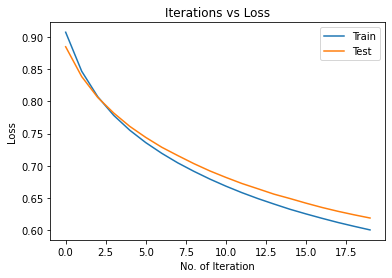

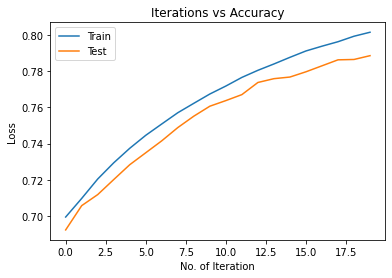

In [14]:

EPOCHS = 20
loss = nn.CrossEntropyLoss()

# In the definition of the optimizer is set:
#   - The parameters of the network to optimaze
#   - The learning rate 
#   - The weight_decay (L2 regularization) = 0.1
optimizer = torch.optim.SGD(ffnet_reg.parameters(), lr=0.001, weight_decay=0.01)

iterations, train_loss, train_accuracy, test_loss, test_accurancy = train(ffnet_reg, train_dataloader, test_dataloader, EPOCHS, loss, optimizer)

plt.plot(iterations, train_loss, label="Train")
plt.plot(iterations, test_loss, label="Test" )
plt.xlabel("No. of Iteration")
plt.ylabel("Loss")
plt.title("Iterations vs Loss")
plt.legend()
plt.show()

plt.plot(iterations, train_accuracy, label="Train")
plt.plot(iterations, test_accurancy, label="Test" )
plt.xlabel("No. of Iteration")
plt.ylabel("Loss")
plt.title("Iterations vs Accuracy")
plt.legend()
plt.show()
        


Accuracy, Loss and confusion matrix of the network trained with regularization

Train Accuracy: 0.8026166558265686
Train lost: 0.5974019765853882
Test Accuracy: 0.7885000109672546
Test lost: 0.6187978982925415


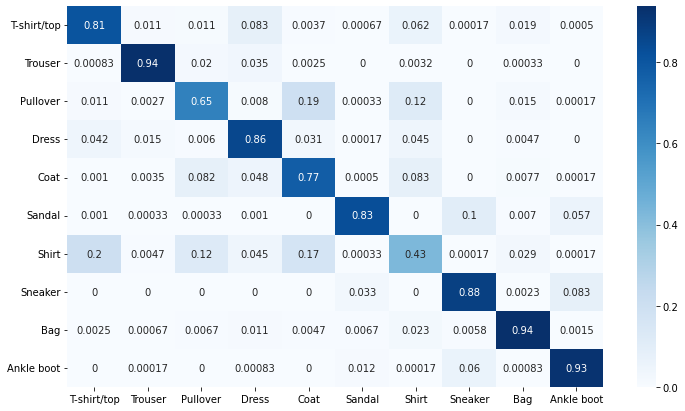

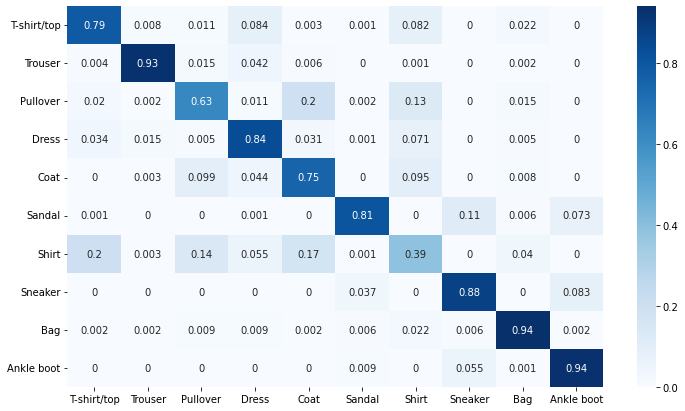

In [15]:
model_performace(ffnet_reg, train_dataloader, test_dataloader)

Let's to see some preditions also with this network with this trained model

In [16]:
# Use the test dataset
images, labels = next(iter(test_dataloader))

# Run the sample through the network
output = ffnet_reg(images)

# Let's check the first 10 classification
for i in range(10): #output.shape[0]
    y_hat = torch.argmax(output[i, :]).item()
    y = labels[i].item()
    print(f'         Image: {i}')
    print(f'Predited label: {lbl_mapping[y_hat]}')
    print(f'  Actual label: {lbl_mapping[y]}')

         Image: 0
Predited label: Sandal
  Actual label: Sandal
         Image: 1
Predited label: Dress
  Actual label: Dress
         Image: 2
Predited label: Coat
  Actual label: Coat
         Image: 3
Predited label: Sandal
  Actual label: Sandal
         Image: 4
Predited label: Dress
  Actual label: T-shirt/top
         Image: 5
Predited label: Dress
  Actual label: Dress
         Image: 6
Predited label: T-shirt/top
  Actual label: Shirt
         Image: 7
Predited label: Trouser
  Actual label: Trouser
         Image: 8
Predited label: Dress
  Actual label: Dress
         Image: 9
Predited label: T-shirt/top
  Actual label: T-shirt/top
